## Some imports

In [ ]:
from google.colab import drive

!pip install rdkit-pypi
!pip install py3Dmol
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

## Data preprocessing
Dataset contains drug-like compounds which can be potential inhibitors of GP120 - CD4 interaction. Compounds are stored in SMILES format. Also data contains binding free energy for molecules.

In [ ]:
DATASETS_FOLDER = '/content/drive/MyDrive/datasets/gp120'

smifile = f'{DATASETS_FOLDER}/gp120_cleaned.csv'
data = pd.read_csv(smifile, header=0)
del data['babel_smiles'], data['filepath_smi']
data.head()

,energy,smiles
0,-8.1,Cc1ccc(C(=O)CN2NN=C(C3CC3)[C@@H]2c2ccccc2F)cc1
1,-8.0,CCOC1=CC(=O)[C@@H](CC2=NNN(CC(=O)c3ccc(C)cc3)[...
2,-7.7,Cc1ccc(C(=O)CN2NN=C(CNC(C)(C)CO)[C@H]2C(C)(C)C...
3,-7.1,Cc1ccc(OC[C@H]2C(CN3CCOCC3)=NNN2CC(=O)c2ccc(C)...
4,-6.8,Cc1ccc(C(=O)CN2NN=C(CCO)[C@@H]2C2(O)CC2)cc1


### Train and test sets creation

In [ ]:
full_train = data.sample(frac=0.8, random_state=42) 
full_test = data.drop(full_train.index)

smiles_train, energy_train = full_train.smiles, full_train.energy
smiles_test, energy_test = full_test.smiles, full_test.energy


print(smiles_train.shape)
print(smiles_test.shape)

(57130,)
(14283,)


### SMILES alphabet

In [ ]:
charset = set("".join(list(data.smiles)) + "!E")
char_to_int = dict((c, i) for i, c in enumerate(charset))
int_to_char = dict((i, c) for i, c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5

print(f'alphabet size: {len(charset)}')
print(f'max smiles len: {embed}')

alphabet size: 32
max smiles len: 95


### SMILES length distribution

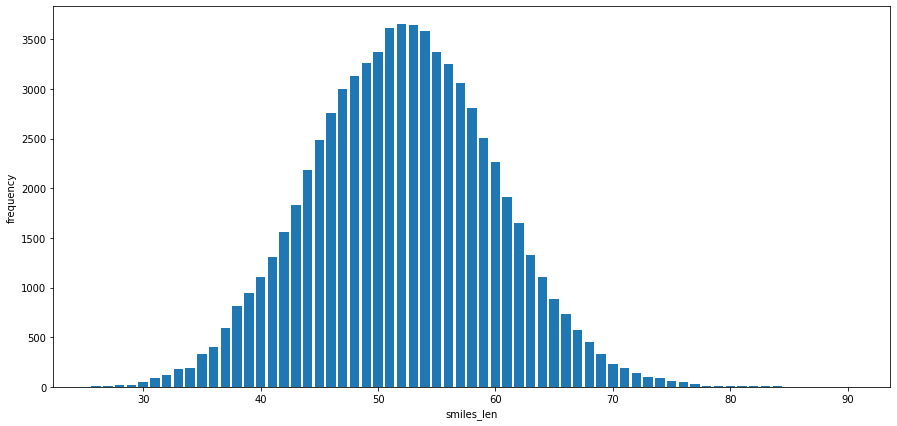

In [ ]:
data['smiles_len'] = np.array([len(smiles) for smiles in data.smiles])
frequencies = data.smiles_len.value_counts()

plt.rcParams["figure.figsize"] = (15, 7)
plt.bar(frequencies.index, frequencies)
plt.xlabel('smiles_len')
plt.ylabel('frequency')
plt.show()

### Distribution of chars frequencies

In [ ]:
from copy import deepcopy

def count_char_freq(char):
    return sum([smile.count(char) for smile in data.smiles])

tmp_char_set = deepcopy(charset)
tmp_char_set.remove('!')
tmp_char_set.remove('E')
tmp_char_set = list(tmp_char_set)


char_freqs = np.array([count_char_freq(char) for char in tmp_char_set])
freqs_df = pd.DataFrame(char_freqs, index=tmp_char_set, columns=['frequency'])
freqs_df = freqs_df.sort_values('frequency')
freqs_df[:10]

,frequency
6,2
.,25
P,27
I,30
5,94
\,1198
o,1795
s,2097
/,5044
+,5671


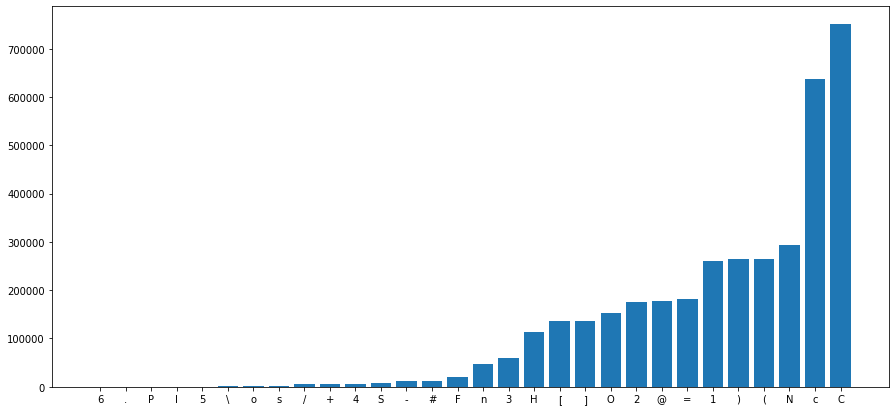

In [ ]:
plt.rcParams["figure.figsize"] = (15, 7)
plt.bar(freqs_df.index, freqs_df.frequency)
plt.show()

### SMILES vectorization

In [ ]:
def vectorize(smiles):
    one_hot = np.zeros((smiles.shape[0], embed, len(charset)), dtype=np.int8)
    for i, smile in enumerate(smiles):
        one_hot[i, 0, char_to_int["!"]] = 1
        for j, c in enumerate(smile):
            one_hot[i, j + 1, char_to_int[c]] = 1
        one_hot[i, len(smile) + 1:, char_to_int["E"]] = 1
    return one_hot[:, 0:-1, :], one_hot[:, 1:, :]

CC[C@@](C)(OC(C)=O)[C@H]1C(CN2CCOCC2)=NNN1CCc1ccc(-c2ncc[nH]2)cc1


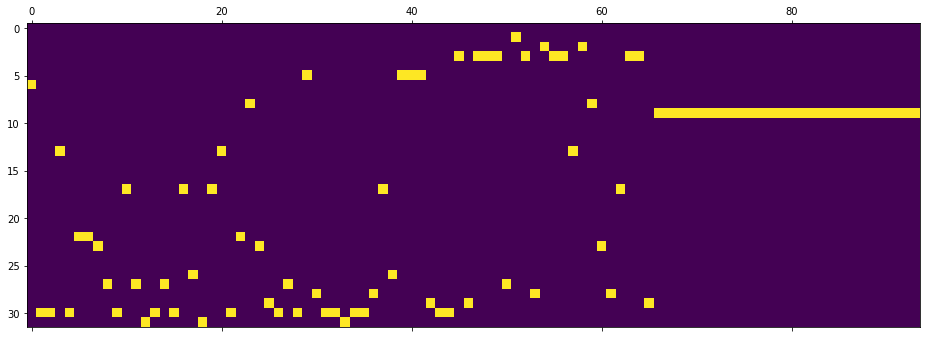

In [ ]:
X_train, Y_train = vectorize(smiles_train.values)
X_test, Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
plt.matshow(X_train[0].T)
plt.show()

### Binding energy scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

energy_train = energy_train.to_frame()
energy_test = energy_test.to_frame()

sc = MinMaxScaler().fit(energy_train)
energy_train = sc.transform(energy_train)
energy_test = sc.transform(energy_test)

## Model definition and training

In [ ]:
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 128
lstm_dim = 128

unroll = False
encoder_inputs = Input(shape=input_shape, name='Smiles_input_1')

encoder_lstm = LSTM(lstm_dim, return_state=True,
                    unroll=unroll, name='Encoder_lstm')

encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

states = Concatenate(axis=-1, name='States_concat')([state_h, state_c])
neck = Dense(latent_dim, activation="relu", name='Encoder_neck')
neck_outputs = neck(states)

free_energy_inputs = Input(shape=(1,), name='Energy_input')
concatenate = Concatenate(axis=-1, name='Energy_concat')
energy_concat = concatenate([neck_outputs, free_energy_inputs])

decode_h = Dense(lstm_dim, name='State_h_decoder', activation="relu")
decode_c = Dense(lstm_dim, name='State_c_decoder', activation="relu")
state_h_decoded = decode_h(energy_concat)
state_c_decoded = decode_c(energy_concat)

encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape, name='Smiles_input_2')


decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    name='Decoder_lstm'
                    )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax', name='Decoder_output')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs, decoder_inputs, free_energy_inputs], decoder_outputs, name='Lstm_autoencoder')
plot_model(model, to_file='model.png', show_layer_activations=True)
print(model.summary())

Model: "Lstm_autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Smiles_input_1 (InputLayer)    [(None, 94, 32)]     0           []                               
                                                                                                  
 Encoder_lstm (LSTM)            [(None, 128),        82432       ['Smiles_input_1[0][0]']         
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 States_concat (Concatenate)    (None, 256)          0           ['Encoder_lstm[0][1]',           
                                                                  'Encoder_lstm[0][

In [ ]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001, verbose=1, min_delta=1e-5)

opt = Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [ ]:
import pickle

def save_history():
    with open("Blog_history.pickle", "wb") as f:
        pickle.dump(h.history, f)

def load_history():
    with open("Blog_history.pickle", "rb") as f:
        h.history = pickle.load(f)

In [ ]:
save_history()
model.fit([X_train, X_train, energy_train], Y_train,
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=([X_test, X_test, energy_test], Y_test))

Epoch 1/50
224/224 [==============================] - 28s 88ms/step - loss: 0.9016 - val_loss: 0.4537 - lr: 0.0050
Epoch 2/50
224/224 [==============================] - 16s 72ms/step - loss: 0.3608 - val_loss: 0.2938 - lr: 0.0050
Epoch 3/50
224/224 [==============================] - 15s 68ms/step - loss: 0.2624 - val_loss: 0.2383 - lr: 0.0050
Epoch 4/50
224/224 [==============================] - 15s 68ms/step - loss: 0.2213 - val_loss: 0.2127 - lr: 0.0050
Epoch 5/50
224/224 [==============================] - 15s 68ms/step - loss: 0.1997 - val_loss: 0.1951 - lr: 0.0050
Epoch 6/50
224/224 [==============================] - 15s 68ms/step - loss: 0.1857 - val_loss: 0.1801 - lr: 0.0050
Epoch 7/50
224/224 [==============================] - 16s 71ms/step - loss: 0.1748 - val_loss: 0.1765 - lr: 0.0050
Epoch 8/50
224/224 [==============================] - 15s 68ms/step - loss: 0.1669 - val_loss: 0.1831 - lr: 0.0050
Epoch 9/50
224/224 [==============================] - 15s 68ms/step - loss: 0.16

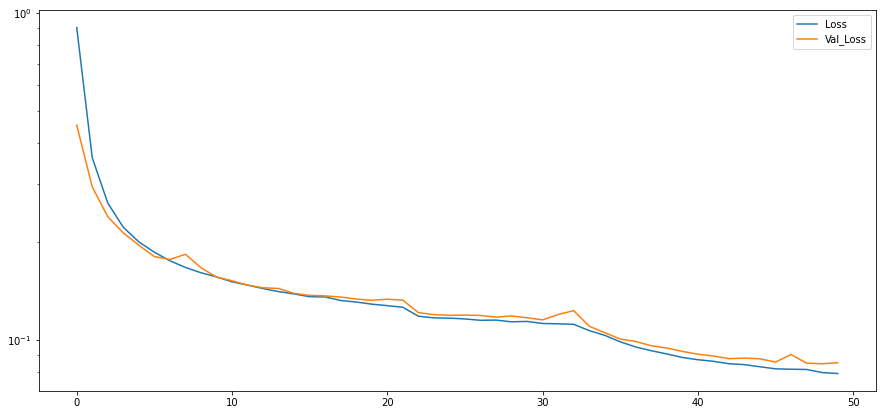

In [ ]:
# save_history()
# load_history()
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()
plt.show()

## Split autoencoder into 2 models

In [ ]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)

In [ ]:
latent_input = Input(shape=(latent_dim,))
energy_input = Input(shape=(1,))

energy_concat_2 = concatenate([latent_input, energy_input])

state_h_decoded_2 = decode_h(energy_concat_2)
state_c_decoded_2 = decode_c(energy_concat_2)

latent_to_states_model = Model([latent_input, energy_input], 
                               [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 Energy_concat (Concatenate)    (None, 129)          0           ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 State_h_decoder (Dense)        (None, 128)          16640       ['Energy_concat[1][0]']    

In [ ]:
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))

inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [ ]:
sample_model.layers[1].set_weights(model.layers[-2].get_weights())
sample_model.layers[2].set_weights(model.layers[-1].get_weights())

sample_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(1, 1, 32)]              0         
                                                                 
 lstm_2 (LSTM)               (1, 1, 128)               82432     
                                                                 
 dense_2 (Dense)             (1, 1, 32)                4128      
                                                                 
Total params: 86,560
Trainable params: 86,560
Non-trainable params: 0
_________________________________________________________________


## New compounds generation

### Latent space creation

In [ ]:
x_latent = smiles_to_latent_model.predict(X_test)

### Converting from latent space to SMILES

In [ ]:
def latent_to_smiles(latent, free_energy):
    states = latent_to_states_model.predict([latent, free_energy])
    sample_model.layers[1].reset_states(states=[states[0], states[1]])
    # adding start char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1, 1, len(charset)))
    samplevec[0,0,startidx] = 1
    smiles = ""
    # predict next symbol
    for i in range(embed):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1, 1, len(charset)))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [ ]:
# comparing original molecule with reconstructed via autoencoder

compound_index = 20

free_energy = energy_test[compound_index]

smiles = latent_to_smiles(x_latent[compound_index:compound_index + 1], free_energy)
print(smiles)
print(smiles_test.iloc[compound_index])

C=CCC1=NNN(c2ccc(C(=O)C=O)cc2)[C@H]1c1ccccc1OC
CCCNCC1=NNN(CC(=O)c2ccc(C)cc2)[C@@H]1c1ccccc1


### Testing validity of generated SMILES
To test if SMILES are reconstructed correctly, 500 compounds from test set were passed through autoencoder, and then some checks were performed.

In [ ]:
from tqdm import tqdm


equal_smiles = 0
valid_smiles = 0

my_range = range(500)

with tqdm(my_range, 
          bar_format="{bar} : {percentage:.2f}% | "
                     "valid: {postfix[0]:.2f}% | "
                     "equal: {postfix[1]:.2f}% | "
                     "elapsed: {elapsed} | "
                     "remaining: {remaining}", 
          postfix=[0, 0]) as t:
    for i in my_range:
        smiles = latent_to_smiles(x_latent[i:i + 1], energy_test[i])
        if smiles == smiles_test.iloc[i]:
            equal_smiles += 1
            valid_smiles += 1  
        elif Chem.MolFromSmiles(smiles):
            valid_smiles += 1
        t.postfix[0] = valid_smiles / (i + 1) * 100
        t.postfix[1] = equal_smiles / (i + 1) * 100
        t.update()


██████████ : 100.00% | valid: 98.20% | equal: 1.20% | elapsed: 24:20 | remaining: 00:00


### Generation from latent space with noise adding
To generate new compounds, we can add random noise vector to `x_latent` and get molecules with similar properties. Also we can set any binding energy we want to achieve.

same: C=CC1=NNN(Cc2ccc(C)c(C)c2)[C@H]1[C@@H]1CCC(=O)N1
same: C=CC1=NNN(Cc2ccc(C)c(C)c2)[C@H]1[C@@H]1CCC(=O)N1
invalid: CCCCCC1=NNN(Cc2ccc(C)c(C)c2)[C@H]1c1ccc(C)nn1C


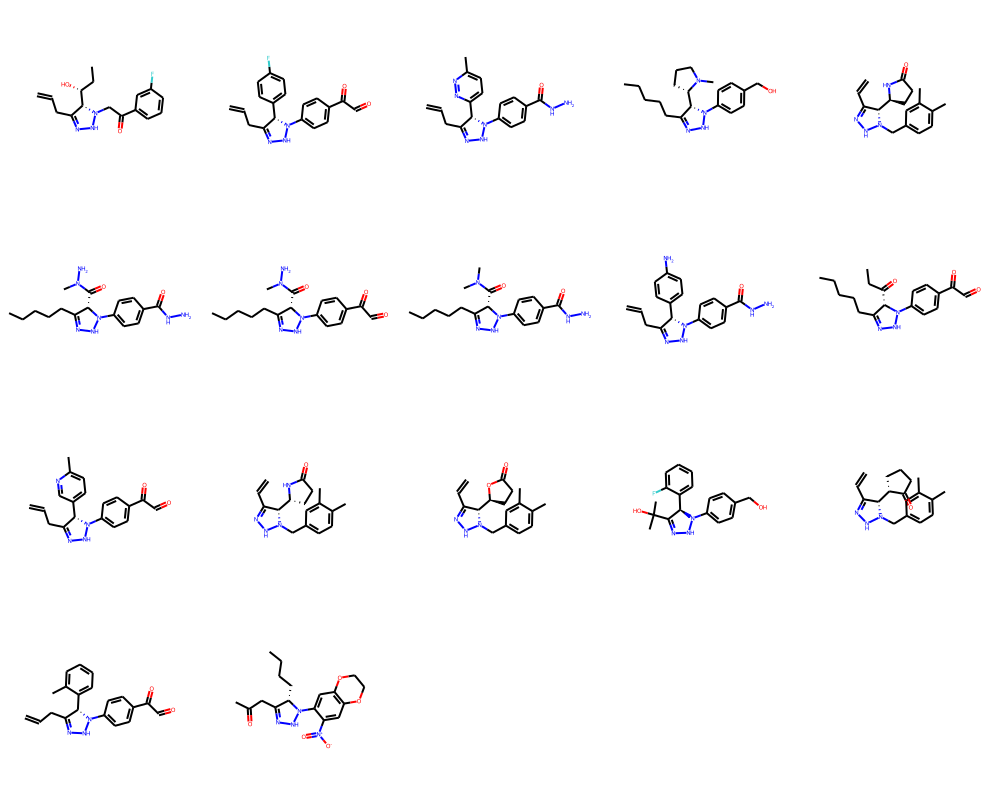

In [ ]:
latent = x_latent[compound_index:compound_index + 1]
scale = 0.5
mols = []
mols_smiles = []
unique_mols = set()


for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1]))
    smiles = latent_to_smiles(latent_r, free_energy)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        if smiles not in unique_mols:
            mols.append(mol)
            mols_smiles.append(smiles)
            unique_mols.add(smiles)
        else:
          print(f'same: {smiles}')
    else:
        print(f'invalid: {smiles}')

Draw.MolsToGridImage(mols, molsPerRow=5)

## 3D molecule visualization

In [ ]:
import py3Dmol

from rdkit import Chem
from rdkit.Chem import AllChem

def makeblock(mol):
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    mblock = Chem.MolToMolBlock(mol)
    return mblock

def render_mol(xyz):
    xyzview = py3Dmol.view()
    xyzview.addModel(xyz,'mol')
    xyzview.setStyle({'stick':{}})
    xyzview.setBackgroundColor('white')
    xyzview.zoomTo()
    xyzview.show()

mol_index = 3

blk = makeblock(mols[mol_index])
print(mols_smiles[mol_index])
render_mol(blk)

CCCCCC1=NNN(c2ccc(CO)cc2)[C@H]1[C@@H]1CCCN1C


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

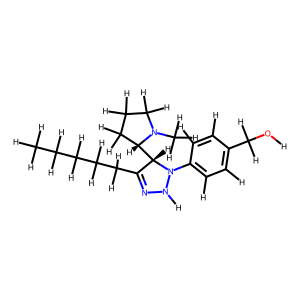

In [ ]:
mol = Chem.AddHs(mols[mol_index])
Draw.MolToImage(mol)